# 03 - Batter Model Training

Train models to predict batter fantasy points per PA.

**Models:** Random Forest, XGBoost, LightGBM (tree-based only to capture non-linear relationships)

**Validation:** Hold out 2024-2025 data for final evaluation

**Target:** `Fpoints_PA` (fantasy points per plate appearance)

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from config.settings import PROCESSED_DATA_DIR, MODELS_DIR, RANDOM_STATE

import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(RANDOM_STATE)

/Applications/miniconda3/envs/pitchml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# print current working directory
import os
print(f"Current working directory: {os.getcwd()}")

# Move to the project root directory
os.chdir('..')
print(f"Changed working directory to: {os.getcwd()}")

Current working directory: /Users/matthewgillies/mlb-fantasy-2026/notebooks
Changed working directory to: /Users/matthewgillies/mlb-fantasy-2026


## Load Data

In [3]:
# Load processed data
df = pd.read_csv(f"{PROCESSED_DATA_DIR}/batters_processed.csv")
print(f"Loaded {len(df)} batter-seasons")
print(f"Years: {df['Season'].min()} - {df['Season'].max()}")
print(f"\nTarget (Fpoints_PA): mean={df['Fpoints_PA'].mean():.3f}, std={df['Fpoints_PA'].std():.3f}")

Loaded 3578 batter-seasons
Years: 2016 - 2025

Target (Fpoints_PA): mean=0.474, std=0.141


In [4]:
# Identify feature columns (lag and rolling features only)
id_cols = ['IDfg', 'Season', 'Name', 'Team']
target_col = 'Fpoints_PA'

# Model features: lag1, lag2, and rolling averages
feature_cols = [c for c in df.columns if '_lag' in c or '_avg' in c]
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature types:")
print(f"  lag1: {len([c for c in feature_cols if '_lag1' in c])}")
print(f"  lag2: {len([c for c in feature_cols if '_lag2' in c])}")
print(f"  rolling avg: {len([c for c in feature_cols if '_avg' in c])}")

Number of features: 50

Feature types:
  lag1: 25
  lag2: 25
  rolling avg: 0


## Train/Validation Split

Hold out 2024-2025 for validation (most recent data).

In [5]:
# Split: train on 2016-2023, validate on 2024-2025
train_years = [2019, 2020, 2021, 2022, 2023, 2024]
val_years = [2025]

train_df = df[df['Season'].isin(train_years)].copy()
val_df = df[df['Season'].isin(val_years)].copy()

print(f"Training set: {len(train_df)} rows ({train_years[0]}-{train_years[-1]})")
print(f"Validation set: {len(val_df)} rows ({val_years[0]}-{val_years[-1]})")

Training set: 2141 rows (2019-2024)
Validation set: 376 rows (2025-2025)


In [6]:
# Prepare X and y
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df[target_col].copy()

# Handle any remaining NaN values (fill with column median from training set)
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_val = X_val.fillna(train_medians)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"\nNaN counts - train: {X_train.isna().sum().sum()}, val: {X_val.isna().sum().sum()}")

X_train shape: (2141, 50)
X_val shape: (376, 50)

NaN counts - train: 0, val: 0


# Random Forest with randomized search
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_cv = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=RANDOM_STATE)
rf_cv.fit(X_train, y_train)

print(f"\nBest RF params: {rf_cv.best_params_}")
print(f"CV MAE: {-rf_cv.best_score_:.4f}")

rf_best = rf_cv.best_estimator_

In [7]:
# Random Forest with hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
rf_cv.fit(X_train, y_train)

print(f"\nBest RF params: {rf_cv.best_params_}")
print(f"CV MAE: {-rf_cv.best_score_:.4f}")

rf_best = rf_cv.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best RF params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
CV MAE: 0.1130


# XGBoost with randomized search
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
xgb_cv = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=RANDOM_STATE)
xgb_cv.fit(X_train, y_train)

print(f"\nBest XGB params: {xgb_cv.best_params_}")
print(f"CV MAE: {-xgb_cv.best_score_:.4f}")

xgb_best = xgb_cv.best_estimator_

In [8]:
# XGBoost with hyperparameter tuning
xgb_params = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [3, 5, 7, 15],
    'learning_rate': [0.001, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'gamma': [0, 1, 5], 
    
}

xgb = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
xgb_cv = RandomizedSearchCV(xgb, xgb_params, n_iter=30, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
xgb_cv.fit(X_train, y_train)

print(f"\nBest XGB params: {xgb_cv.best_params_}")
print(f"CV MAE: {-xgb_cv.best_score_:.4f}")

xgb_best = xgb_cv.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best XGB params: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
CV MAE: 0.1123


# LightGBM with randomized search
lgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],
    'subsample': [0.7, 0.8, 1.0]
}

lgb = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
lgb_cv = RandomizedSearchCV(lgb, lgb_params, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=RANDOM_STATE)
lgb_cv.fit(X_train, y_train)

print(f"\nBest LGB params: {lgb_cv.best_params_}")
print(f"CV MAE: {-lgb_cv.best_score_:.4f}")

lgb_best = lgb_cv.best_estimator_

In [9]:
# LightGBM with hyperparameter tuning
lgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0]
}

lgb = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
lgb_cv = GridSearchCV(lgb, lgb_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
lgb_cv.fit(X_train, y_train)

print(f"\nBest LGB params: {lgb_cv.best_params_}")
print(f"CV MAE: {-lgb_cv.best_score_:.4f}")

lgb_best = lgb_cv.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best LGB params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}
CV MAE: 0.1128


In [10]:
def evaluate_model(model, X, y, model_name):
    """Evaluate model and return metrics."""
    y_pred = model.predict(X)
    
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Evaluate all models
results = []
results.append(evaluate_model(rf_best, X_val, y_val, 'Random Forest'))
results.append(evaluate_model(xgb_best, X_val, y_val, 'XGBoost'))
results.append(evaluate_model(lgb_best, X_val, y_val, 'LightGBM'))

results_df = pd.DataFrame(results)
print("\n=== Validation Results ===")
print(results_df.to_string(index=False))


=== Validation Results ===
        Model      MAE     RMSE       R²
Random Forest 0.091412 0.116897 0.251323
      XGBoost 0.092269 0.117745 0.240427
     LightGBM 0.092351 0.117743 0.240453


In [11]:
# Select best model based on MAE
best_model_name = results_df.loc[results_df['MAE'].idxmin(), 'Model']
print(f"\nBest model: {best_model_name}")

# Get the best model object
models = {
    'Random Forest': rf_best,
    'XGBoost': xgb_best,
    'LightGBM': lgb_best
}

best_model = models[best_model_name]
needs_scaling = False  # Tree models don't need scaling


Best model: Random Forest


In [12]:
# Select best model based on MAE
best_model_name = results_df.loc[results_df['MAE'].idxmin(), 'Model']
print(f"\nBest model: {best_model_name}")

# Get the best model object
models = {
    'Random Forest': (rf_best, False),
    'XGBoost': (xgb_best, False),
    'LightGBM': (lgb_best, False)
}

best_model, needs_scaling = models[best_model_name]


Best model: Random Forest


# Get feature importance from tree-based model
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

In [13]:
# Get feature importance from best tree-based model
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    # For linear models, use coefficients
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': np.abs(best_model.coef_)
    }).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
        feature  importance
     xwOBA_lag1    0.121165
       xBA_lag1    0.061953
        K%_lag1    0.045781
     xwOBA_lag2    0.040039
       xBA_lag2    0.035676
O-Contact%_lag1    0.033967
      xSLG_lag1    0.032224
       Spd_lag1    0.030311
        K%_lag2    0.026838
     Hard%_lag1    0.025287
     maxEV_lag1    0.024396
       LD%_lag1    0.020265
       FB%_lag1    0.020040
     Pull%_lag1    0.019966
       Age_lag1    0.018092
     HR/FB_lag1    0.017958
      xSLG_lag2    0.017752
     Zone%_lag1    0.017142
Z-Contact%_lag1    0.016406
  Z-Swing%_lag1    0.016206


In [14]:
# Calculate SHAP values for tree-based model
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_val)
# Ensure feature names are attached
shap_values.feature_names = feature_cols
print(f"SHAP values calculated for {len(X_val)} validation samples")

SHAP values calculated for 376 validation samples


## SHAP Analysis

In [15]:
# Calculate SHAP values for tree-based models
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X_val)
    print(f"SHAP values calculated for {len(X_val)} validation samples")
else:
    # For linear models, use Linear explainer
    explainer = shap.LinearExplainer(best_model, X_val_scaled)
    shap_values = explainer(X_val_scaled)
    print(f"SHAP values calculated for {len(X_val)} validation samples")

SHAP values calculated for 376 validation samples


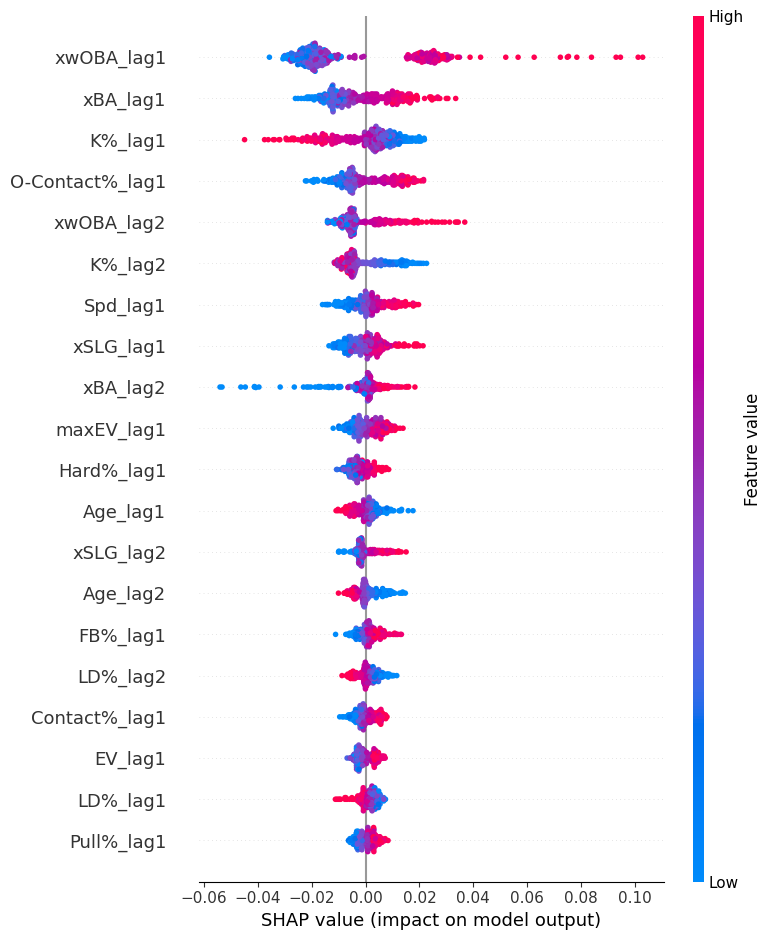

In [16]:
# SHAP summary plot
feature_names = feature_cols
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_val, feature_names=feature_names, max_display=20, show=False)
plt.tight_layout()
plt.show()

In [17]:
def predict_player(player_name, season, show_shap=True):
    """
    Predict fantasy points for a specific player and season.
    Shows SHAP waterfall plot for explainability.
    
    Args:
        player_name: Player name (partial match supported)
        season: Season year (e.g., 2024)
        show_shap: Whether to display SHAP waterfall plot
    
    Returns:
        dict with prediction details
    """
    # Find player
    mask = df['Name'].str.contains(player_name, case=False) & (df['Season'] == season)
    player_df = df[mask]
    
    if len(player_df) == 0:
        print(f"Player '{player_name}' not found in {season}")
        # Show similar names
        similar = df[df['Name'].str.contains(player_name, case=False)]['Name'].unique()
        if len(similar) > 0:
            print(f"Similar names: {similar[:5]}")
        return None
    
    if len(player_df) > 1:
        print(f"Multiple matches found: {player_df['Name'].values}")
        player_df = player_df.iloc[[0]]
    
    player_row = player_df.iloc[0]
    X_player = player_df[feature_cols].fillna(train_medians)
    
    # Predict
    if needs_scaling:
        X_player_scaled = scaler.transform(X_player)
        pred = best_model.predict(X_player_scaled)[0]
    else:
        pred = best_model.predict(X_player)[0]
    
    actual = player_row['Fpoints_PA']
    error = pred - actual
    
    print(f"\n=== {player_row['Name']} ({season}) ===")
    print(f"Team: {player_row['Team']}")
    print(f"PA: {player_row['PA']:.0f}")
    print(f"\nActual Fpoints/PA: {actual:.3f}")
    print(f"Predicted Fpoints/PA: {pred:.3f}")
    print(f"Error: {error:+.3f}")
    
    # Project total points (using actual PA)
    total_actual = actual * player_row['PA']
    total_pred = pred * player_row['PA']
    print(f"\nTotal Fpoints (actual PA):")
    print(f"  Actual: {total_actual:.0f}")
    print(f"  Predicted: {total_pred:.0f}")
    
    # SHAP waterfall
    if show_shap:
        if needs_scaling:
            player_shap = explainer(X_player_scaled)
        else:
            player_shap = explainer(X_player)
        player_shap.data = X_player.values
        player_shap.feature_names = feature_cols
        plt.figure(figsize=(10, 8))
        shap.plots.waterfall(player_shap[0], max_display=15, show=False)
        plt.title(f"SHAP Waterfall: {player_row['Name']} ({season})")
        plt.tight_layout()
        plt.show()
    
    return {
        'name': player_row['Name'],
        'season': season,
        'actual': actual,
        'predicted': pred,
        'error': error,
        'pa': player_row['PA']
    }


=== Aaron Judge (2024) ===
Team: NYY
PA: 704

Actual Fpoints/PA: 0.895
Predicted Fpoints/PA: 0.762
Error: -0.133

Total Fpoints (actual PA):
  Actual: 630
  Predicted: 536


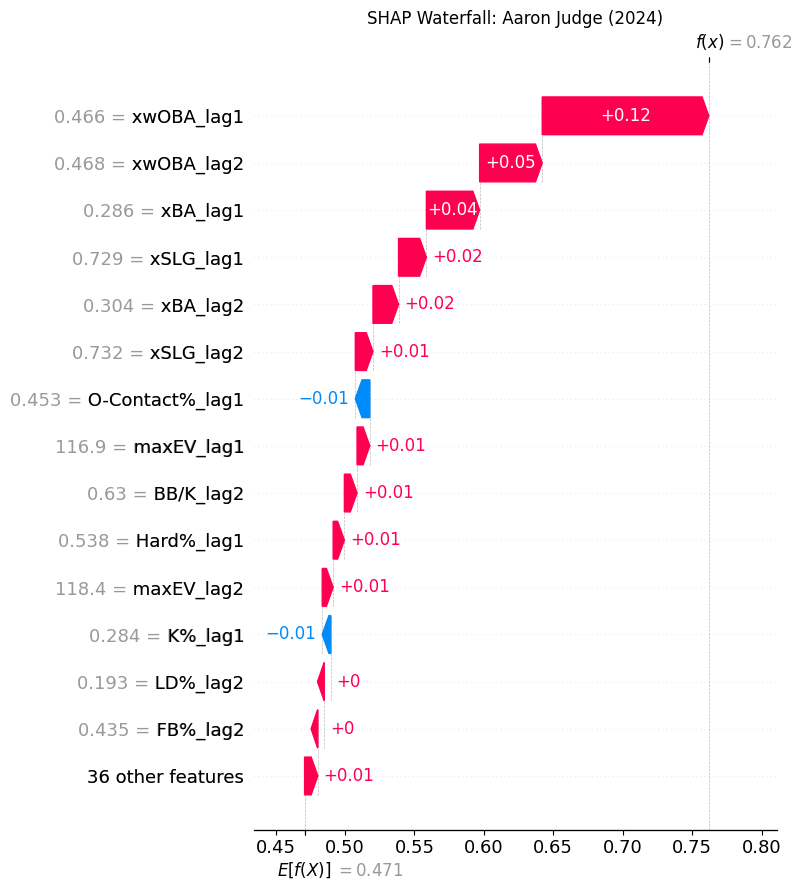

{'name': 'Aaron Judge',
 'season': 2024,
 'actual': np.float64(0.8948863636363636),
 'predicted': np.float64(0.7620203788747993),
 'error': np.float64(-0.1328659847615643),
 'pa': np.int64(704)}

In [18]:
# Example: predict for a specific player
predict_player("Aaron Judge", 2024)


=== Tyler Soderstrom (2025) ===
Team: ATH
PA: 624

Actual Fpoints/PA: 0.571
Predicted Fpoints/PA: 0.473
Error: -0.098

Total Fpoints (actual PA):
  Actual: 356
  Predicted: 295


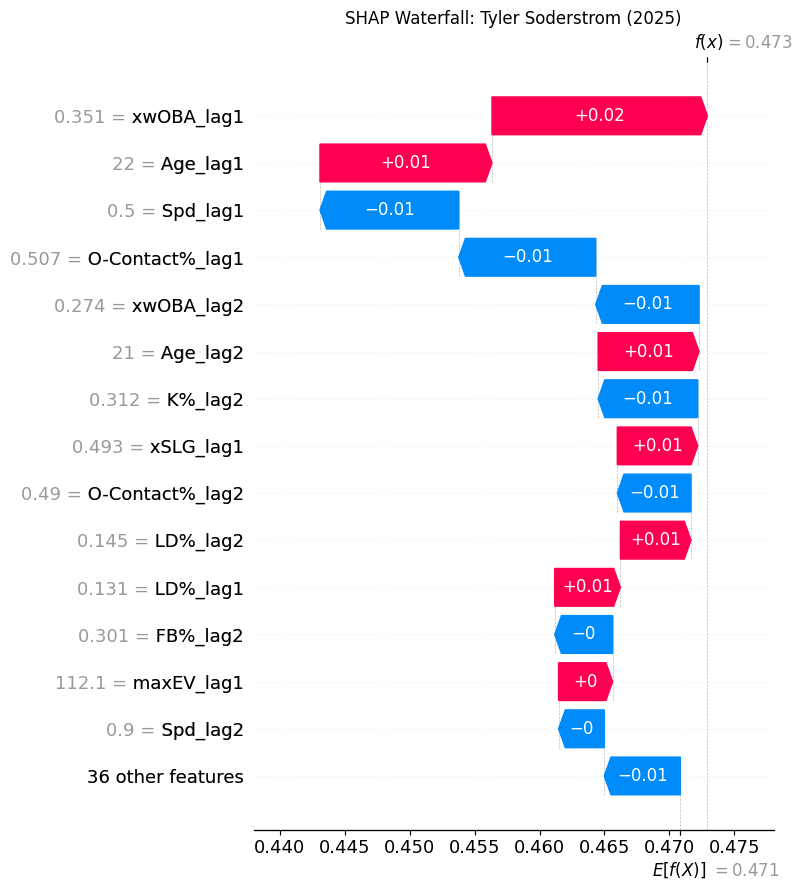

{'name': 'Tyler Soderstrom',
 'season': 2025,
 'actual': np.float64(0.5705128205128205),
 'predicted': np.float64(0.4729345886481269),
 'error': np.float64(-0.09757823186469361),
 'pa': np.int64(624)}

In [27]:
# Try another player
predict_player("Tyler Soderstrom", 2025)

## 2025 Predictions & Comparison

In [20]:
def predict_season(season):
    """
    Predict for all players in a given season and compare to actuals.
    
    Returns DataFrame with predictions and actuals.
    """
    season_df = df[df['Season'] == season].copy()
    
    if len(season_df) == 0:
        print(f"No data for {season}")
        return None
    
    X_season = season_df[feature_cols].fillna(train_medians)
    
    if needs_scaling:
        X_season_scaled = scaler.transform(X_season)
        preds = best_model.predict(X_season_scaled)
    else:
        preds = best_model.predict(X_season)
    
    results = season_df[['Name', 'Team', 'PA', 'Fpoints_PA']].copy()
    results['Predicted'] = preds
    results['Error'] = results['Predicted'] - results['Fpoints_PA']
    results['Abs_Error'] = results['Error'].abs()
    
    # Calculate total points
    results['Actual_Total'] = results['Fpoints_PA'] * results['PA']
    results['Predicted_Total'] = results['Predicted'] * results['PA']
    
    # Sort by predicted total
    results = results.sort_values('Predicted_Total', ascending=False)
    
    return results


def show_season_summary(season):
    """
    Show summary of predictions for a season.
    """
    results = predict_season(season)
    if results is None:
        return
    
    print(f"\n=== {season} Prediction Summary ===")
    print(f"Players: {len(results)}")
    print(f"MAE: {results['Abs_Error'].mean():.4f}")
    print(f"RMSE: {np.sqrt((results['Error']**2).mean()):.4f}")
    
    # Correlation between predicted and actual rankings
    results['Actual_Rank'] = results['Actual_Total'].rank(ascending=False)
    results['Predicted_Rank'] = results['Predicted_Total'].rank(ascending=False)
    rank_corr = results['Actual_Rank'].corr(results['Predicted_Rank'])
    print(f"Rank Correlation: {rank_corr:.3f}")
    
    print(f"\nTop 15 Predicted:")
    display_cols = ['Name', 'Team', 'PA', 'Fpoints_PA', 'Predicted', 'Actual_Total', 'Predicted_Total']
    print(results[display_cols].head(15).to_string(index=False))
    
    return results

In [21]:
# Show 2025 predictions
results_2025 = show_season_summary(2025)


=== 2025 Prediction Summary ===
Players: 376
MAE: 0.0914
RMSE: 0.1169
Rank Correlation: 0.946

Top 15 Predicted:
                 Name  Team  PA  Fpoints_PA  Predicted  Actual_Total  Predicted_Total
            Juan Soto   NYM 715    0.777622   0.741525         556.0       530.190491
        Shohei Ohtani   LAD 727    0.784044   0.726379         570.0       528.077577
          Aaron Judge   NYY 679    0.882180   0.711524         599.0       483.124539
       Bobby Witt Jr.   KCR 687    0.671033   0.690447         461.0       474.337403
Vladimir Guerrero Jr.   TOR 680    0.658824   0.674259         448.0       458.496029
     Francisco Lindor   NYM 732    0.639344   0.620722         468.0       454.368502
         Jose Ramirez   CLE 673    0.775632   0.665243         522.0       447.708365
        Rafael Devers - - - 729    0.576132   0.612095         420.0       446.217527
          Kyle Tucker   CHC 597    0.703518   0.734100         420.0       438.257631
   Vinnie Pasquantino   KC

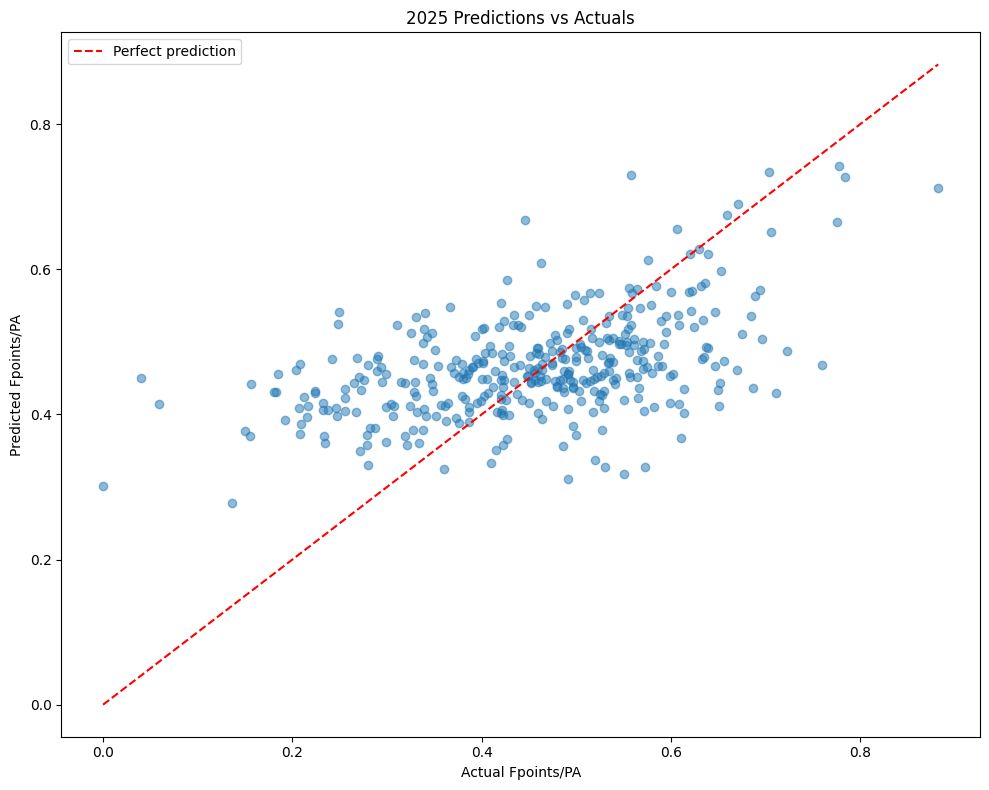

In [22]:
# Scatter plot: predicted vs actual
if results_2025 is not None:
    plt.figure(figsize=(10, 8))
    plt.scatter(results_2025['Fpoints_PA'], results_2025['Predicted'], alpha=0.5)
    
    # Add diagonal line
    min_val = min(results_2025['Fpoints_PA'].min(), results_2025['Predicted'].min())
    max_val = max(results_2025['Fpoints_PA'].max(), results_2025['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    
    plt.xlabel('Actual Fpoints/PA')
    plt.ylabel('Predicted Fpoints/PA')
    plt.title('2025 Predictions vs Actuals')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [23]:
# Show 2024 predictions as well
results_2024 = show_season_summary(2024)


=== 2024 Prediction Summary ===
Players: 383
MAE: 0.0449
RMSE: 0.0613
Rank Correlation: 0.987

Top 15 Predicted:
                 Name  Team  PA  Fpoints_PA  Predicted  Actual_Total  Predicted_Total
        Shohei Ohtani   LAD 731    0.893297   0.772437         653.0       564.651373
            Juan Soto   NYY 713    0.816269   0.761690         582.0       543.084861
          Aaron Judge   NYY 704    0.894886   0.762020         630.0       536.462347
         Jose Ramirez   CLE 682    0.847507   0.719364         578.0       490.605947
       Bobby Witt Jr.   KCR 709    0.832158   0.683691         590.0       484.737194
Vladimir Guerrero Jr.   TOR 697    0.737446   0.677281         514.0       472.064587
       Yordan Alvarez   HOU 635    0.735433   0.731726         467.0       464.645925
     Gunnar Henderson   BAL 719    0.671766   0.609454         483.0       438.197782
      Freddie Freeman   LAD 638    0.650470   0.679815         415.0       433.721851
     Francisco Lindor   NY

## Save Best Model

In [24]:
import os
os.makedirs(MODELS_DIR, exist_ok=True)

# Save model and metadata
model_data = {
    'model': best_model,
    'model_name': best_model_name,
    'scaler': scaler if needs_scaling else None,
    'needs_scaling': needs_scaling,
    'feature_cols': feature_cols,
    'train_medians': train_medians,
    'train_years': train_years,
    'val_results': results_df.to_dict()
}

model_path = f"{MODELS_DIR}/batter_model.joblib"
joblib.dump(model_data, model_path)
print(f"Model saved to {model_path}")

Model saved to models/batter_model.joblib


## Interactive Player Lookup

Use the cells below to look up any player.


=== Mookie Betts (2024) ===
Team: LAD
PA: 516

Actual Fpoints/PA: 0.758
Predicted Fpoints/PA: 0.706
Error: -0.051

Total Fpoints (actual PA):
  Actual: 391
  Predicted: 365


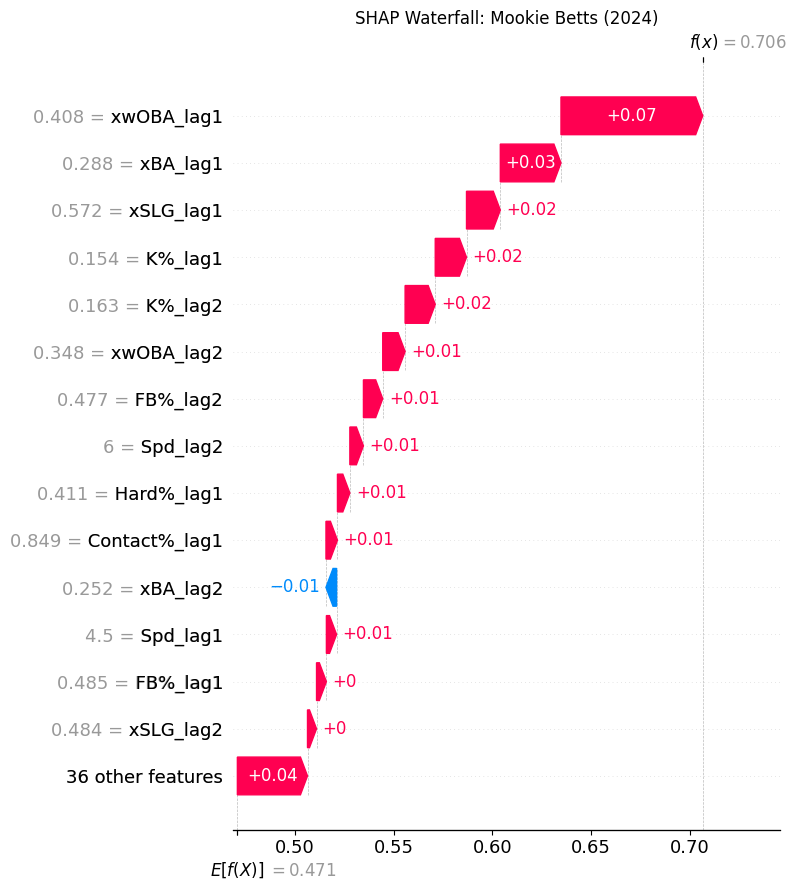

{'name': 'Mookie Betts',
 'season': 2024,
 'actual': np.float64(0.7577519379844961),
 'predicted': np.float64(0.7064783807939107),
 'error': np.float64(-0.05127355719058546),
 'pa': np.int64(516)}

In [25]:
# Change player name and year as needed
predict_player("Mookie Betts", 2024)

In [26]:
# List available players for a year
year = 2025
players = df[df['Season'] == year].sort_values('Fpoints_PA', ascending=False)
print(f"Top 20 batters by Fpoints/PA in {year}:")
print(players[['Name', 'Team', 'PA', 'Fpoints_PA']].head(20).to_string(index=False))

Top 20 batters by Fpoints/PA in 2025:
                 Name  Team  PA  Fpoints_PA
          Aaron Judge   NYY 679    0.882180
        Shohei Ohtani   LAD 727    0.784044
            Juan Soto   NYM 715    0.777622
         Jose Ramirez   CLE 673    0.775632
      George Springer   TOR 586    0.759386
          Cal Raleigh   SEA 705    0.721986
      Geraldo Perdomo   ARI 720    0.711111
          Ketel Marte   ARI 556    0.705036
          Kyle Tucker   CHC 597    0.703518
       Kyle Schwarber   PHI 724    0.696133
          Josh Naylor - - - 604    0.693709
       Corbin Carroll   ARI 642    0.688474
      Junior Caminero   TBR 653    0.686064
       Cody Bellinger   NYY 656    0.684451
         Byron Buxton   MIN 542    0.675277
       Bobby Witt Jr.   KCR 687    0.671033
         Miguel Amaya   CHC 103    0.669903
Vladimir Guerrero Jr.   TOR 680    0.658824
      Shea Langeliers   ATH 523    0.655832
     Ronald Acuna Jr.   ATL 412    0.652913
